## Week 6 - Linear Regression

In this tutorial, we will use linear regression models on a real estate dataset to predict the house price per unit area. Building linear regression model means estimating a set of weights (one weight per feature, plus an extra weight called the bias or the intercept) on a dataset. 

The model estimated is a linear model taking the form:

$target\_feature = w_0 + w_1 * feature_1 + w_2*feature_2 + ...+ w_n*feature_n $



#### Table of contents (for easy navigation): 

<a href="#SLR">Part A: Simple Linear Regression</a>    
<a href="#MLR">Part B: Multi-linear Regression</a>    
<a href="#SGDR">Part C: Stochastic Gradient Descent Regression</a>

#### Import Packages

In [1]:
# Library Imports.

import numpy as np
import pandas as pd

# Allows plots to appear directly in the notebook.
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

#### Load Data

In [2]:
dataframe = pd.read_csv('Real estate.csv', sep=',', index_col=0)
print('Dimensions: ', dataframe.shape)
dataframe.head()

Dimensions:  (414, 7)


,TransactionDate,HouseAge,NearestMRTStationDistance,ConvenienceStoresCount,Latitude,Longitude,HousePricePerUnitArea
No,,,,,,,
1,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
2,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
3,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3
4,2013.500,13.3,561.98450,5,24.98746,121.54391,54.8
5,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1


There are 6 features namely, 
- `TransactionDate` : The date when the house was sold
- `HouseAge` : number of years since the house is built
- `NearestMRTStationDistance` : Distance to the nearest mass rapid transit station
- `ConvenienceStoresCount` : count of the convenience stores nearby
- `Latitude` and `Longitude` : coordinate location of the house

The target variable is the `HousePricePerUnitArea`, a continuous variable.

In [3]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 414 entries, 1 to 414
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   TransactionDate            414 non-null    float64
 1   HouseAge                   414 non-null    float64
 2   NearestMRTStationDistance  414 non-null    float64
 3   ConvenienceStoresCount     414 non-null    int64  
 4   Latitude                   414 non-null    float64
 5   Longitude                  414 non-null    float64
 6   HousePricePerUnitArea      414 non-null    float64
dtypes: float64(6), int64(1)
memory usage: 25.9 KB


### Understanding the data

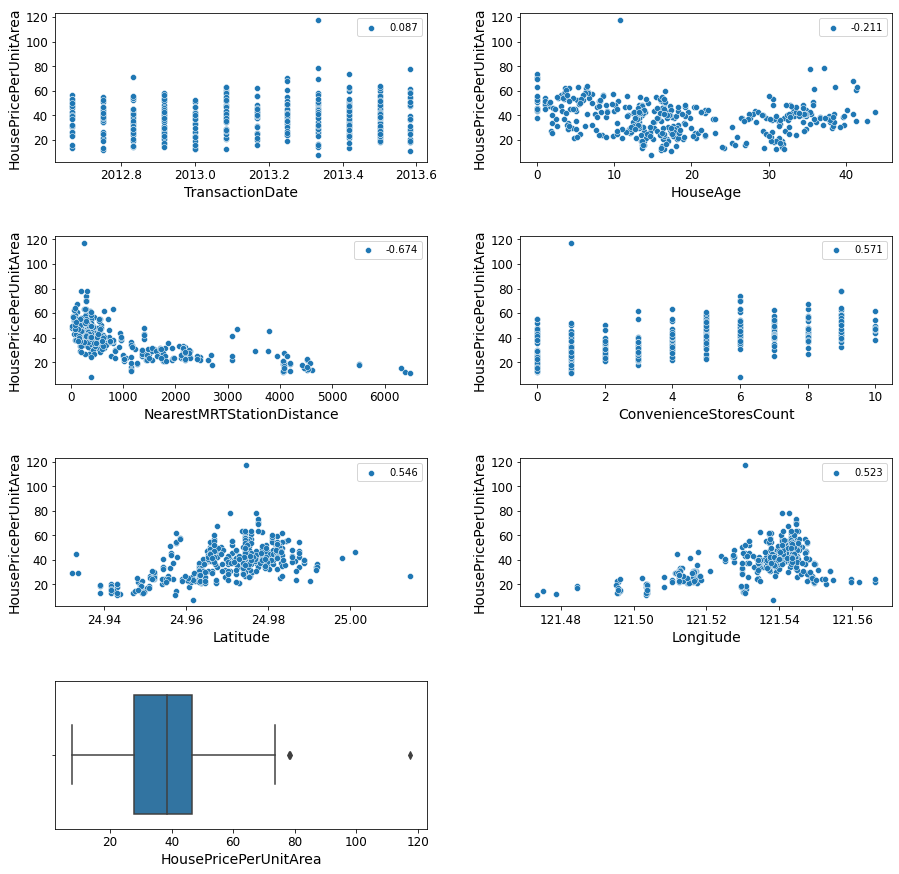

In [4]:
with plt.rc_context({'xtick.labelsize':12, 'ytick.labelsize':12, 'axes.labelsize':14}):
    fig, axs = plt.subplots(4, 2, figsize=(15,15))
    sns.scatterplot(ax=axs[0,0], x=dataframe['TransactionDate'], y=dataframe['HousePricePerUnitArea'], 
                    label="%.3f" % dataframe[['TransactionDate', 'HousePricePerUnitArea']].corr().to_numpy()[0,1])
    sns.scatterplot(ax=axs[0,1], x=dataframe['HouseAge'], y=dataframe['HousePricePerUnitArea'], 
                    label="%.3f" % dataframe[['HouseAge', 'HousePricePerUnitArea']].corr().to_numpy()[0,1])
    sns.scatterplot(ax=axs[1,0], x=dataframe['NearestMRTStationDistance'], y=dataframe['HousePricePerUnitArea'], 
                    label="%.3f" % dataframe[['NearestMRTStationDistance', 'HousePricePerUnitArea']].corr().to_numpy()[0,1])
    sns.scatterplot(ax=axs[1,1], x=dataframe['ConvenienceStoresCount'], y=dataframe['HousePricePerUnitArea'], 
                    label="%.3f" % dataframe[['ConvenienceStoresCount', 'HousePricePerUnitArea']].corr().to_numpy()[0,1])
    sns.scatterplot(ax=axs[2,0], x=dataframe['Latitude'], y=dataframe['HousePricePerUnitArea'], 
                    label="%.3f" % dataframe[['Latitude', 'HousePricePerUnitArea']].corr().to_numpy()[0,1])
    sns.scatterplot(ax=axs[2,1], x=dataframe['Longitude'], y=dataframe['HousePricePerUnitArea'], 
                    label="%.3f" % dataframe[['Longitude', 'HousePricePerUnitArea']].corr().to_numpy()[0,1])
    sns.boxplot(ax=axs[3,0], x=dataframe['HousePricePerUnitArea'])
    axs[3,1].axis('off')
    plt.subplots_adjust(hspace=0.5, wspace=0.25)

In regression problems, presence of outliers can influence the regression line and also the Pearson correlation, therefore preprocessing should be carried out to remove/clamp the outliers on a case-to-case basis. From the plots above, we see that the observation with `HousePricePerUnitArea` > 120 seems to be an outlier for all the features. Therefore, let's drop the observation for the time being and compute the correlation.

In [5]:
dataframe.drop(dataframe[dataframe['HousePricePerUnitArea'] > 100].index, inplace=True)
dataframe.corr()

,TransactionDate,HouseAge,NearestMRTStationDistance,ConvenienceStoresCount,Latitude,Longitude,HousePricePerUnitArea
TransactionDate,1.000000,0.018528,0.061988,0.011321,0.034373,-0.040805,0.081734
HouseAge,0.018528,1.000000,0.024676,0.048131,0.055119,-0.048822,-0.210985
NearestMRTStationDistance,0.061988,0.024676,1.000000,-0.605328,-0.590805,-0.807079,-0.694009
ConvenienceStoresCount,0.011321,0.048131,-0.605328,1.000000,0.445994,0.449239,0.612635
Latitude,0.034373,0.055119,-0.590805,0.445994,1.000000,0.413249,0.563954
Longitude,-0.040805,-0.048822,-0.807079,0.449239,0.413249,1.000000,0.549250
HousePricePerUnitArea,0.081734,-0.210985,-0.694009,0.612635,0.563954,0.549250,1.000000


The correlation values have changed from what we had seen on the graphs above after dropping the observation which was an outlier. 

<a id=SLR></a>
### Part A: Simple Linear Regression

In [6]:
X, y = dataframe[['ConvenienceStoresCount']], dataframe['HousePricePerUnitArea']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [7]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [8]:
#https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
regressor = LinearRegression().fit(X_train_scaled, y_train)

In [9]:
# Print the estimated linear regression coefficients.
print("Features: ", 'ConvenienceStoresCount')
print("\nCoeficients: ", regressor.coef_)
print("\nIntercept: ", regressor.intercept_)

Features:  ConvenienceStoresCount

Coeficients:  [8.08873741]

Intercept:  37.78187702265373


In [10]:
# Predicted scores for each example. 
y_predicted = regressor.predict(X_test_scaled)

actual_vs_predicted = pd.concat([y_test, pd.DataFrame(y_predicted, columns=['Predicted'], index=y_test.index)], axis=1)
actual_vs_predicted.head(10)

,HousePricePerUnitArea,Predicted
No,,
202,45.9,40.479281
30,57.1,40.479281
103,54.4,43.266900
409,28.1,34.904044
187,25.7,34.904044
223,48.5,54.417374
243,33.4,34.904044
293,24.5,40.479281
172,58.8,40.479281


Some of the predictions are the same. This is because the `ConvenienceStoresCount` can have the same value for multiple houses, the regressor that learns to predict the price of the house based on this feature only does not learn much. 

In [11]:
#This function is used repeatedly to compute all metrics
def printMetrics(testActualVal, predictions, number_of_features=1):
    #classification evaluation measures
    print("MAE: ", metrics.mean_absolute_error(testActualVal, predictions))
    print("MAPE: ", metrics.mean_absolute_percentage_error(testActualVal, predictions)* 100)
    print("RMSE: ", metrics.mean_squared_error(testActualVal, predictions)**0.5)
    print("Adjusted R2: ", 1 - ( 1-metrics.r2_score(testActualVal, predictions)) * ( len(predictions) - 1 ) / ( len(predictions) - number_of_features - 1 )) 

In [12]:
printMetrics(y_test, y_predicted)

MAE:  8.548648699723874
MAPE:  26.839176572860072
RMSE:  10.590763187967397
Adjusted R2:  0.335712283918135


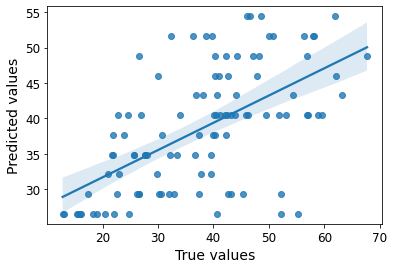

In [13]:
with plt.rc_context({'xtick.labelsize':12, 'ytick.labelsize':12, 'axes.labelsize':14}):
    ax = sns.regplot(x=y_test, y=y_predicted);
    ax.set(ylabel='Predicted values', xlabel='True values');

For `ConvenienceStoresCount`, we see that the different evaluation metrics are quite high and R2 which is the coefficient of determination is quite low. So, let's include other features in the model and evaluate if the model's performance improves.

<a id=MLR></a>
### Part B: Multilinear Regression

In [14]:
#Excluding the 'TransactionDate as it doesn't add much value to the data
X = dataframe[['HouseAge', 'NearestMRTStationDistance','ConvenienceStoresCount','Latitude','Longitude']]
y = dataframe['HousePricePerUnitArea']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [15]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [16]:
#https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
regressor = LinearRegression().fit(X_train_scaled, y_train)

In [17]:
# Print the estimated linear regression coefficients.
print("\nCoeficients: ", regressor.coef_)
print("\nIntercept: ", regressor.intercept_)


Coeficients:  [-2.47597231 -4.3424933   3.93240799  3.0634214   0.43521353]

Intercept:  37.781877022653596


In [18]:
# Predicted scores for each example. 
y_predicted = regressor.predict(X_test_scaled)

#print("Predicted scores:", predicted_scores)
actual_vs_predicted = pd.concat([y_test, pd.DataFrame(y_predicted, columns=['Predicted'], index=y_test.index)], axis=1)
actual_vs_predicted.head(10)

,HousePricePerUnitArea,Predicted
No,,
202,45.9,46.676195
30,57.1,45.581331
103,54.4,46.544445
409,28.1,30.631523
187,25.7,30.057431
223,48.5,48.405837
243,33.4,34.637495
293,24.5,38.585089
172,58.8,47.744888


In [19]:
printMetrics(y_test, y_predicted, number_of_features=5)

MAE:  5.751866720348405
MAPE:  17.333729904591003
RMSE:  7.61208661488868
Adjusted R2:  0.6428231968689972


Although the mean squared errors are still > 0, we can observe that adjusted R2 has improved from ~33% to ~64%. This implies that ~64% of the variation in the `HousePricePerUnitArea` can be explained by the features considered in the model. 

<a id=SGDR></a>
### Part C: Stochastic Gradient Descent Regressor

In [20]:
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html
from sklearn.linear_model import SGDRegressor
sgd_regressor = SGDRegressor(max_iter=50, tol=1e-3, random_state=42).fit(X_train_scaled, y_train)

In [21]:
# Print the estimated linear regression coefficients.
print("\nCoeficients: ", sgd_regressor.coef_)
print("\nIntercept: ", sgd_regressor.intercept_)


Coeficients:  [-2.48359516 -4.03486931  3.95394297  3.0807514   0.60477434]

Intercept:  [37.75829866]


In [22]:
# Predicted scores for each example. 
y_predicted = sgd_regressor.predict(X_test_scaled)

#print("Predicted scores:", predicted_scores)
actual_vs_predicted = pd.concat([y_test, pd.DataFrame(y_predicted, columns=['Predicted'], index=y_test.index)], axis=1)
actual_vs_predicted.head(10)

,HousePricePerUnitArea,Predicted
No,,
202,45.9,46.672339
30,57.1,45.571909
103,54.4,46.405323
409,28.1,30.618536
187,25.7,30.044317
223,48.5,48.316903
243,33.4,34.621786
293,24.5,38.388466
172,58.8,47.695781


In [23]:
printMetrics(y_test, y_predicted, number_of_features=5)

MAE:  5.76766406166962
MAPE:  17.33773820192752
RMSE:  7.628200859052726
Adjusted R2:  0.6413093606134895


### Additional Reading: 

1. [Introduction to Regression](https://www.joshuapkeller.com/page/introregression/slr.html) specifies the assumptions of regression and also provides the interpretation of the parameters estimated using regression. 
2. [Linear regression in Python](http://www.dataschool.io/linear-regression-in-python/) is a very well written notebook that contains many useful details and gives pointers to further reading. 